# T2 CC6204 - Deep Learning

### **Por: Álvaro Morales Torres**

26-10-2023

Trabajado en local con CUDA y PyTorch

SPECS:

**CPU**: AMD Ryzen 7 5700XX (8 Core) @4.5 GHz.

**GPU**: NVIDIA GeForce RTX 3060 Ti (8GB VRAM).

16 GB RAM @ 3200 MHz.

# Transfer Learning

En este notebook resolveremos un problema real usando redes pre-entrenadas y transfer learning.

## Patrones geométricos de Kunisch
En el año 1998, Norbert Kunisch (un reconocido arqueólogo clásico alemán) publicó su libro "Ornamente Geometrischer Vasen", en donde clasificó diferentes patrones geométricos de vasijas griegas que se encuentran en diferentes museos de Europa. Su trabajo fue muy importante para determinar tiempos y ubicaciones de muchos objetos esparcidos por todo el continente.

Su libro es un compendio de los diferentes patrones geométricos presentes en vasijas y las anotaciones textuales de los patrones en diferentes idiomas.

<img src="http://www.ivan-sipiran.com/downloads/0.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/6.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/36.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/92.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/210.jpg" alt="Test" height="200" />








# El problema

En el museo de arqueología Schloss Eggenberg quieren realizar un análisis automático de patrones en vasijas usando el compendio de Kunisch. Para esto nosotros realizamos primero un trabajo de escaneo del libro entero y de OCR para extraer tanto los patrones como las anotaciones textuales.

Como resultado tenemos 348 patrones, clasificados en seis clases:

*   Ornamentos circulares
*   Ornamentos triangulares
*   Ornamenros rectangulares
*   Pictografías
*   Trazos y líneas
*   Romboidales

Nuestro primer objetivo es encontrar una forma de lograr una alta eficacia de clasificación de estos patrones. Sin embargo, al tener muy poca data, trataremos de resolverlo con la técnica dle transfer learning.



In [1]:
#Descargamos la data
!wget http://www.ivan-sipiran.com/downloads/data_patterns2.zip
!unzip data_patterns2.zip

--2023-10-23 01:17:59--  http://www.ivan-sipiran.com/downloads/data_patterns2.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28575047 (27M) [application/zip]
Saving to: 'data_patterns2.zip'

     0K .......... .......... .......... .......... ..........  0%  134K 3m27s
    50K .......... .......... .......... .......... ..........  0%  272K 2m35s
   100K .......... .......... .......... .......... ..........  0% 24.2M 1m43s
   150K .......... .......... .......... .......... ..........  0% 35.7M 78s
   200K .......... .......... .......... .......... ..........  0%  262K 83s
   250K .......... .......... .......... .......... ..........  1% 39.2M 69s
   300K .......... .......... .......... .......... ..........  1% 40.3M 59s
   350K .......... .......... .......... .......... ..........  1% 32.2M 52s
   400K ........

Archive:  data_patterns2.zip
   creating: data/
  inflating: data/class_labels.csv
  inflating: data/0.jpg
  inflating: data/6.jpg
  inflating: data/36.jpg
  inflating: data/92.jpg
  inflating: data/210.jpg
   creating: data/patrones/
   creating: data/patrones/69c/
  inflating: data/patrones/69c/69c_pattern.png
   creating: data/patrones/2a/
  inflating: data/patrones/2a/2a_pattern.png
   creating: data/patrones/2h/
  inflating: data/patrones/2h/2h_pattern.png
   creating: data/patrones/3b/
  inflating: data/patrones/3b/3b_pattern.png
   creating: data/patrones/3g/
  inflating: data/patrones/3g/3g_pattern.png
   creating: data/patrones/3h/
  inflating: data/patrones/3h/3h_pattern.png
   creating: data/patrones/4a/
  inflating: data/patrones/4a/4a_pattern.png
   creating: data/patrones/4b/
  inflating: data/patrones/4b/4b_pattern.png
   creating: data/patrones/4c/
  inflating: data/patrones/4c/4c_pattern.png
   creating: data/patrones/4d/
  inflating: data/patrones/4d/4d_pattern.png
  

# La Solución

Primero creamos nuestras tres colecciones de datos: train, val y test. Los datos de train serán usados para entrenar el modelo, los datos de validación serán usados para probar el modelo durante entrenamiento, y los datos de test serán usados para evaluar el performance final del modelo.

Hacemos un poco de data engineering para crear nuestras colecciones.

*   Datos de train: 70%
*   Datos de val: 10%
*   Datos de test: 20%

La partición se hace dentro de cada clase para asegurar representatividad en cada clase.



In [361]:
import pandas as pd
import math
import random
import os
import shutil
import cv2

random.seed(30)

#Leemos la metadata del dataset desde el archivo CSV

df = pd.read_csv('data/class_labels.csv', header=None)
classes = df[1].unique()
classesFinal = [cl.replace(' ', '_') for cl in classes]
print(classesFinal)

#Creamos folders para almacenar la data. NOTA: trata de ejecutar esta celda solo una vez, ya que
# crea los folders y ese paso solo se ejecuta una vez
try:
  os.mkdir('dataset')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/train')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/test')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

try:
  os.mkdir('dataset/val')
except OSError:
  print ("No se pudo crear folder dataset")
else:
  print ("Se creó folder dataset")

for cl in classesFinal:
  try:
    os.mkdir(os.path.join('dataset', "train", cl))
  except OSError:
    print (f"No se pudo crear folder train {cl}")
  else:
    print (f"Se creó folder train {cl}")

  try:
    os.mkdir(os.path.join('dataset', "test", cl))
  except OSError:
    print (f"No se pudo crear folder test {cl}")
  else:
    print (f"Se creó folder test {cl}")

  try:
    os.mkdir(os.path.join('dataset', "val", cl))
  except OSError:
    print (f"No se pudo crear folder val {cl}")
  else:
    print (f"Se creó folder val {cl}")


['circular_ornaments', 'triangular_ornaments', 'rectangular_ornaments', 'pictographics', 'lozenge', 'strokes_and_lines']
Se creó folder dataset
Se creó folder dataset
Se creó folder dataset
Se creó folder dataset
Se creó folder train circular_ornaments
Se creó folder test circular_ornaments
Se creó folder val circular_ornaments
Se creó folder train triangular_ornaments
Se creó folder test triangular_ornaments
Se creó folder val triangular_ornaments
Se creó folder train rectangular_ornaments
Se creó folder test rectangular_ornaments
Se creó folder val rectangular_ornaments
Se creó folder train pictographics
Se creó folder test pictographics
Se creó folder val pictographics
Se creó folder train lozenge
Se creó folder test lozenge
Se creó folder val lozenge
Se creó folder train strokes_and_lines
Se creó folder test strokes_and_lines
Se creó folder val strokes_and_lines


In [362]:
# DATA AUGMENTATION
# The overfitting just won't die!!!
# data augmentation function.
# adding flipped versions of the images
def augment_image(image_path, output_path, class_folder, prefix):
    img = cv2.imread(image_path)
    
    # Horizontal flip
    horizontal_flip = cv2.flip(img, 1)
    horizontal_output_path = os.path.join(output_path, class_folder, f"{prefix}_h.png")
    cv2.imwrite(horizontal_output_path, horizontal_flip)
    
    # Vertical flip
    # vertical_flip = cv2.flip(img, 0)
    # vertical_output_path = os.path.join(output_path, class_folder, f"{prefix}_v.png")
    # cv2.imwrite(vertical_output_path, vertical_flip)

#Hacemos el pre-procesamiento de los datos, cada imagen va a parar a su respectivo folder
dataset = dict()

for index, cl in enumerate(classes):
    grouped_data = df.groupby(1).get_group(cl)[0].tolist()
    dataset[classesFinal[index]] = grouped_data

for k,v in dataset.items():
    print(f'Class: {k}, Length: {len(v)}')

for k,v in dataset.items():
    valNumber = math.ceil(0.1 * len(v))
    testNumber = math.ceil(0.2 * len(v))
    trainNumber = len(v) - valNumber - testNumber

    random.shuffle(v)
    elemTrain = v[:trainNumber]
    elemVal = v[trainNumber:trainNumber+valNumber]
    elemTest = v[trainNumber+valNumber:]

    assert (valNumber + testNumber + trainNumber) == len(v)

    pathTrain = './dataset/train/'
    pathSource = './data/patrones/'

    #Copiar archivos de train
    for elem in elemTrain:
        # original image
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathTrain, k))
        # augmented image copies
        augment_image(os.path.join(pathSource, elem, f"{elem}_pattern.png"), pathTrain, k, elem)

    pathTest = './dataset/test/'
    pathSource = './data/patrones/'

    #Copiar archivos de test
    for elem in elemTest:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathTest, k))

    pathVal = './dataset/val/'
    pathSource = './data/patrones/'

    #Copiar archivos de validación
    for elem in elemVal:
        # original image
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathVal, k))
        # augmented image copies
        # augment_image(os.path.join(pathSource, elem, f"{elem}_pattern.png"), pathVal, k, elem)

Class: circular_ornaments, Length: 72
Class: triangular_ornaments, Length: 81
Class: rectangular_ornaments, Length: 87
Class: pictographics, Length: 26
Class: lozenge, Length: 46
Class: strokes_and_lines, Length: 36


# Creación de Datasets

Se crean los datasets y dataloaders de Pytorch, que usarás para tu tarea.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy

pathDataset = 'dataset/'

train_dataset = torchvision.datasets.ImageFolder(pathDataset + 'train',
                                                    transform = transforms.Compose([
                                                        transforms.RandomVerticalFlip(),
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.RandomResizedCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

val_dataset = torchvision.datasets.ImageFolder(pathDataset + 'val',
                                                    transform = transforms.Compose([ transforms.Resize(256),
                                                                    transforms.CenterCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

test_dataset = torchvision.datasets.ImageFolder(pathDataset + 'test',
                                                    transform = transforms.Compose([ transforms.Resize(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


In [2]:
# how many of each do we have?
print(f'Train: {len(train_dataset)}')
print(f'Val: {len(val_dataset)}')
print(f'Test: {len(test_dataset)}')

Train: 472
Val: 38
Test: 74


In [70]:
# random stuff. start running here:
import random
SEED = 777

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Solución 1: Fine-tuning

Utiliza fine-tuning para el problema anterior y reporta el accuracy de test. Intenta obtener el accuracy de test más alto posible, sin que el modelo haga overfitting. Considera overfitting cuando la diferencia entre accuracy de train y accuracy de validación tengan una diferencia de más de 5%.



In [71]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
NUM_EPOCHS = 21 # took some tries to find a good number here.

In [72]:
# gpu?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [73]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  '''
  Trains a model and returns it,
  along with 4 arrays containing the test losses, val losses, test accs, and val accs for each epoch
  '''
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_losses, val_losses, train_accs, val_accs = [], [], [], []
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    
    #Train model
    scheduler.step()
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss /len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_acc = epoch_acc
      
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    #Validation 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    epoch_loss = running_loss /len(val_dataset)
    epoch_acc = running_corrects.double() / len(val_dataset)
      
    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    if epoch_acc >= best_acc and abs(epoch_acc - train_acc) < 0.05:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    val_losses.append(epoch_loss)
    val_accs.append(epoch_acc)

  time_elapsed = time.time() - since
  print('!!! Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best val accucary: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model, train_losses, val_losses, train_accs, val_accs

In [74]:
# choosen model after some testing. resnet18 is small enough to not overfit too quickly (in theory)
model = models.resnet18(pretrained=True)

c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
# fine tuning
num_ft = model.fc.in_features
dropout_prob = 0.65

# New fully connected layer with dropout
model.fc = nn.Sequential(
    nn.Linear(num_ft, 32),  # Layer
    nn.ReLU(),              # Activation fn
    nn.Dropout(p=dropout_prob),  # Dropout layer
    nn.Linear(32, 6)       # 6 output classes
)

model = model.to(device)

critertion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [76]:
# train
model_ft, train_losses, val_losses, train_accs, val_accs = train_model(model, critertion, optimizer, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/20
----------


c:\Users\alvar\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Loss: 1.6717 Acc: 0.3114
Val Loss: 1.3698 Acc: 0.4737
Epoch 1/20
----------
Train Loss: 1.4555 Acc: 0.4195
Val Loss: 1.3750 Acc: 0.4474
Epoch 2/20
----------
Train Loss: 1.2906 Acc: 0.4873
Val Loss: 1.2775 Acc: 0.5526
Epoch 3/20
----------
Train Loss: 1.2331 Acc: 0.4958
Val Loss: 1.1390 Acc: 0.5526
Epoch 4/20
----------
Train Loss: 1.1720 Acc: 0.5530
Val Loss: 1.2711 Acc: 0.5000
Epoch 5/20
----------
Train Loss: 1.0893 Acc: 0.5911
Val Loss: 1.2458 Acc: 0.5263
Epoch 6/20
----------
Train Loss: 1.0652 Acc: 0.5975
Val Loss: 1.0394 Acc: 0.5789
Epoch 7/20
----------
Train Loss: 1.0275 Acc: 0.6059
Val Loss: 1.0235 Acc: 0.6316
Epoch 8/20
----------
Train Loss: 1.0111 Acc: 0.5826
Val Loss: 1.0563 Acc: 0.6053
Epoch 9/20
----------
Train Loss: 0.9229 Acc: 0.6483
Val Loss: 1.0060 Acc: 0.6316
Epoch 10/20
----------
Train Loss: 0.8959 Acc: 0.6483
Val Loss: 1.0436 Acc: 0.6053
Epoch 11/20
----------
Train Loss: 0.8607 Acc: 0.6356
Val Loss: 1.0627 Acc: 0.6053
Epoch 12/20
----------
Train Loss: 0

In [77]:
# get the accs out of the gpu for plotting
train_accs = [x.cpu().numpy() for x in train_accs]
val_accs = [x.cpu().numpy() for x in val_accs]

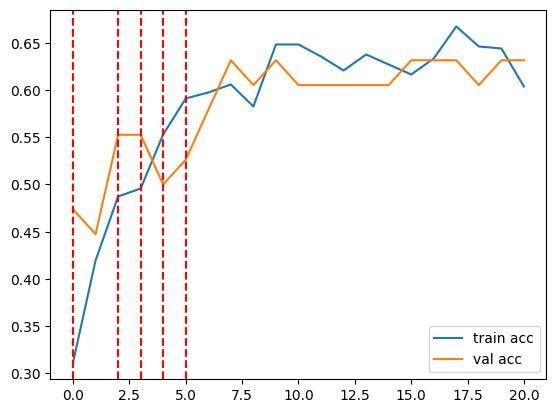

In [78]:
# plot the accs
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='val acc')
plt.legend()
# mark with a vertical line the points where the difference in accuracy is greater than 5%
for i in range(len(train_accs)):
  if abs(train_accs[i] - val_accs[i]) > 0.05:
    plt.axvline(x=i, color='r', linestyle='--')
plt.show()


In [79]:
# seems that's as good as it's gonna get. shame.
# time to test and report the accuracy
def calculate_accuracy(y_pred, y):
    # Round the predicted values to the nearest integer (class)
    y_pred_rounded = torch.argmax(y_pred, dim=1)
    # Compare the predicted classes with the true classes
    correct = (y_pred_rounded == y).float()
    # Calculate accuracy
    acc = correct.sum() / len(correct)
    return acc

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    #We put the network in testing mode
    #In this mode, Pytorch doesn't use features only reserved for 
    #training (dropout for instance)    
    model.eval()
    
    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)
            y = y.to(device)
            #We get the predictions
            y_pred = model(x)
            #We compute the loss
            loss = criterion(y_pred, y)
            #We compute the accuracy
            acc = calculate_accuracy(y_pred, y)
            #We update the loss and the accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [80]:
# here we go
test_loss, test_acc = evaluate(model_ft, test_loader, critertion, device)
print(f'Test loss: {test_loss:.3f} | Test acc: {100*test_acc:.2f}')

Test loss: 0.735 | Test acc: 68.92


In [81]:
# That's as good as i could get it, not particularly impressive, but i have to move on.
# However, note that the test accuracy went up by a bit when compared to the validation accuracy. (63%->68%, diff of 5%)

# Solución 2: Freezing

Utiliza freezing para el problema anterior y reporta el accuracy de test. Intenta obtener el accuracy de test más alto posible, sin que el modelo haga overfitting. Considera overfitting
ting cuando la diferencia entre accuracy de train y accuracy de validación tengan una diferencia de más de 5%.

In [82]:
model_conv = models.resnet18(pretrained=True)

In [83]:
# freezing, in effect, means that the parameters of the model will not be updated during training
# they are "frozen" and will remain the same, while the new outter-most layer is trained
for param in model_conv.parameters():
    param.requires_grad = False

In [84]:
num_ft = model_conv.fc.in_features
dropout_prob = 0.59
# 6 classes + dropout to prevent overfitting
model_conv.fc = nn.Sequential(
    nn.Linear(num_ft, 24),  # Layer
    nn.ReLU(),              # activation fn
    nn.Dropout(p=dropout_prob),  # dropout
    nn.Linear(24, 6)       # 6 output classes
)

model_conv = model_conv.to(device)

critertion = nn.CrossEntropyLoss()
optimizer_conv = torch.optim.SGD(model_conv.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=0.02)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [85]:
model_conv, train_losses, val_losses, train_accs, val_accs = train_model(model_conv, critertion, optimizer_conv, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/20
----------


Train Loss: 1.7893 Acc: 0.2182
Val Loss: 1.6431 Acc: 0.3684
Epoch 1/20
----------
Train Loss: 1.6390 Acc: 0.3581
Val Loss: 1.5244 Acc: 0.4211
Epoch 2/20
----------
Train Loss: 1.5183 Acc: 0.4364
Val Loss: 1.4754 Acc: 0.3947
Epoch 3/20
----------
Train Loss: 1.4035 Acc: 0.4661
Val Loss: 1.4087 Acc: 0.4211
Epoch 4/20
----------
Train Loss: 1.3621 Acc: 0.4513
Val Loss: 1.4004 Acc: 0.4737
Epoch 5/20
----------
Train Loss: 1.2077 Acc: 0.5657
Val Loss: 1.2778 Acc: 0.5000
Epoch 6/20
----------
Train Loss: 1.2201 Acc: 0.5233
Val Loss: 1.3163 Acc: 0.4737
Epoch 7/20
----------
Train Loss: 1.3012 Acc: 0.4958
Val Loss: 1.2424 Acc: 0.5789
Epoch 8/20
----------
Train Loss: 1.2522 Acc: 0.5169
Val Loss: 1.2920 Acc: 0.5000
Epoch 9/20
----------
Train Loss: 1.3003 Acc: 0.4809
Val Loss: 1.2650 Acc: 0.5263
Epoch 10/20
----------
Train Loss: 1.2064 Acc: 0.5233
Val Loss: 1.3047 Acc: 0.5263
Epoch 11/20
----------
Train Loss: 1.1631 Acc: 0.5614
Val Loss: 1.3068 Acc: 0.4737
Epoch 12/20
----------
Train Loss: 1

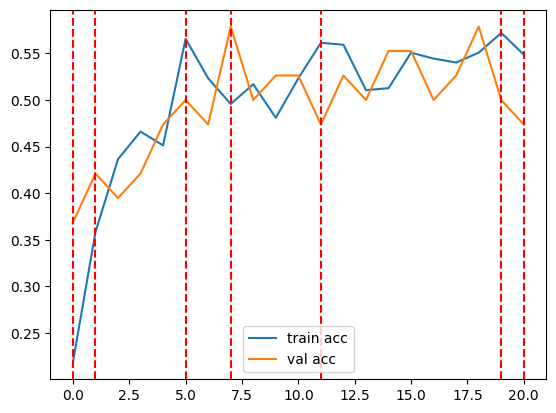

In [86]:
# get the accs out of the gpu for plotting
train_accs = [x.cpu().numpy() for x in train_accs]
val_accs = [x.cpu().numpy() for x in val_accs]

# plot the accs
plt.plot(train_accs, label='train acc')
plt.plot(val_accs, label='val acc')
plt.legend()
# mark with a vertical line the points where the difference in accuracy is greater than 5%
for i in range(len(train_accs)):
  if abs(train_accs[i] - val_accs[i]) > 0.05:
    plt.axvline(x=i, color='r', linestyle='--')
plt.show()

In [87]:
# This is as good as it's gonna get.
# I know, not particularly nice looking,
# but constraining the validation accuracy was WAY harder that with fine-tuning.
# and yet:
test_loss, test_acc = evaluate(model_conv, test_loader, critertion, device)
print(f'Test loss: {test_loss:.3f} | Test acc: {100*test_acc:.2f}')

Test loss: 0.873 | Test acc: 71.62


In [88]:
# Overall worse performance than fine-tuning.
# But note that the test accuracy went up by a lot, relatively to the accuracy of the validation. Considerably more than Fine-tuning. (58%->72% diff of 14%)

Ok, resumiendo:

La idea de hacer trasnfer learning es tomar un modelo pre-entrenado con un dataset grande y luego usarlo para resolver un problema más específico con considerablemente menos data. Para esto, se puede usar fine-tuning o freezing.

La diferencia clave entre estos 2 métodos es que en fine-tuning se entrena todo el modelo, mientras que en freezing se entrena solo la última capa, es decir, sin tocar los pesos pre-entrenados.

Ahora, en este caso en particular teníamos muy poca data para trabajar, por lo que se tuvieron que usar varias técnicas para evitar el overfitting.

Data Augmentation en el dataset de train, Dropout en las capas de clasificación, y tunear el weight decay para los 2 métodos con tal de minimizar el overfitting, y que los resultados sean en ciero modo comparables.

En general, se logró reducir el overfitting, pero no eliminarlo por completo. Definitivamente debe haber una mejor combinación de técnicas y parámetros, pero en el intento de balancear rendimiento en testing y overfitting, se llegó a esto.

Tal vez haya una mejor combinación de modelo pre-entrenado y optimizador, pero decidí usar resnet18 debido a que al ser poca data, un modelo más chico debería, en toría, hacer menos overfitting. Algunos tests con vgg11 parecieron indicar que esto es cierto. Lógica similar me llevó a usar SGD en vez de algo como Adam, por ejemplo. Sin embargo no me cierro a la posibilidad de que haya una mejor combinación de modelo pre-entrenado y optimizador. Tal vez haya algo se ajuste mejor a los datos.

Lo que nos lleva a ¿qué podemos observar de los resultados?

Notemos que en fine-tuning, durante el training se alcanzó un accuracy de validación máximo de 63%, mientras que el accuracy de test fue de 68%. Por algún motivo mejoró por un poco, la diferencia es de 5%.

Mientras que a freezing le fue peor durante el training, solo se alcanzó un accuracy de validación máximo de 58%, el accuracy de test fue de 72%. Aunque no me atrevo a decir que este sea un resultado muy representativo de las fortalezas del método en sí, ya que la diferecia en los accuracy de test no es mucha. Esto podría ser un fluke. Pero notemos que la diferencia entre el acc de validación y acc de test es considerablemente mayor: 14%.

¿Hay alguna intuición que pueda explicar esto?

En cierta forma es esperable que fine-tuning sea mejor que freezing para tan poca data. Con pocos datos, no podemos extender demasiado el modelo, y como en freezing congelamos todos los pesos del modelo pre-entrenado, es más dificil que el modelo aprenda de los nuevos datos. Todo el nuevo aprendizaje solo puede ocurrir en las capas de clasificiación. Fine-tuning tiene más flexibilidad para adaptarse a los nuevos datos, ya que todos los pesos se pueden modificar, incluyendo los pesos pre-entrenados.

Pero esto último podría ser un arma de doble filo. Como todos los pesos pueden cambiar, es posible que, al aprender de la nueva data, se olviden cosas importantes del dataset entrenado, a favor de aprender cosas del dataset de train. En efecto, fine-tuning corre el riesgo de estropear el conocimiento pre-entrenado. Esto explicaría por qué el accuracy aumenta de validación a testing, y por qué esta diferencia es más pronunciada en freezing. Como en freezing no se pueden cambiar los pesos pre-entrenados, no olvidará ciertos patrones que podrían aplicar a los datos de test.

Podemos intuir que la razón por la que freezing fue peor en validación, es porque estamos con poca data. Al congelar los pesos de la red pre-entrenada, tenemos menos parámetros para ajustar, lo cual dificulta el aprendizaje. Sería interesante ver qué pasa si se usa freezing con más data. Con más data podríamos tener una cabeza de clasificación mucho más grande, y por lo tanto más parámetros para ajustar. Tal vez sea posible que con suficiente data, freezing supere a fine-tuning, al no correr el riesgo de estropear el conocimiento pre-entrenado que se mencionó antes.